In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

# task 1.2
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# task 1.3
from sklearn.model_selection import StratifiedKFold

# task 2.1
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import (
    KMeans, Birch, AffinityPropagation, AgglomerativeClustering)

# task 3.1
import scipy
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# task 3.2

import plotly
from plotly.offline import (
    download_plotlyjs, init_notebook_mode, plot, iplot)
import plotly.graph_objs as go
import colorlover as cl

from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# Home Assignment No. 3: Part 1 (Theory and Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1. Practice with Different Anomaly Detection Algorithms. (5 points)
### Task 1.1. (1 point)
Explore two One-Class SVM methods, write down corresponding minimization functions (try to keep equal notations) and explain the differences (1-2 sentences).
1. Scholkopf et al.: http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf
2. Tax et al.:  https://link.springer.com/content/pdf/10.1023/B:MACH.0000008084.60811.49.pdf

#### Your solution:

$\langle\langle\textbf{Your Latex Code}\rangle\rangle$

### Task 1.2. (2 points)

1. **(1 pt.)** For the `frod_detection` dataset,  predict the anomaly with any three sklearn built-in Anomaly detection methods: https://scikit-learn.org/stable/modules/outlier_detection.html

**Note:** do not forget to relabel predictions from Anomaly detection methods, as they could be negative.

2. **(1 pt.)** Estimate the __contamination__ (or impurity) on the training set as the ratio of anomaly objects in the whole sample. Explore, how the `roc_auc_score` changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [3]:
data = pd.read_csv('data/creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1, stratify=y, random_state= 42)

In [4]:
# impurity estimation on train data
contamination = y_train.sum() / len(y_train)
# relabeling
y_test[y_test > 0] = -1
y_test[y_test == 0] = 1

In [5]:
svm = OneClassSVM() # very slow
isof = IsolationForest(n_jobs=-1)
lof = LocalOutlierFactor(novelty=True, n_jobs=-1)

for C in [svm, isof, lof]:
    print(C.__class__.__name__)
    print('------------------')
    for i in [0.1, 1, 10]:
        # >>> your solution here <<<
        C.contamination = i * contamination 
        C.fit(X_train)
        y_pred = C.predict(X_test)
        print('Contamination: ', np.round(contamination * i, 3), ' ', 
              'ROC/AUC: ', np.round(roc_auc_score(y_test, y_pred), 3),
              'Precision: ', np.round(precision_score(y_test, y_pred, average = 'micro'), 3))
    print()

OneClassSVM
------------------
Contamination:  0.002   ROC/AUC:  0.536 Precision:  0.501
Contamination:  0.017   ROC/AUC:  0.536 Precision:  0.501
Contamination:  0.17   ROC/AUC:  0.536 Precision:  0.501

IsolationForest
------------------
Contamination:  0.002   ROC/AUC:  0.51 Precision:  0.983
Contamination:  0.017   ROC/AUC:  0.772 Precision:  0.986
Contamination:  0.17   ROC/AUC:  0.851 Precision:  0.845

LocalOutlierFactor
------------------
Contamination:  0.002   ROC/AUC:  0.499 Precision:  0.981
Contamination:  0.017   ROC/AUC:  0.499 Precision:  0.962
Contamination:  0.17   ROC/AUC:  0.505 Precision:  0.815



***IsolationForest performs the best***

### Task 1.3. (2 points)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance.

As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. **(1 pt.)** Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 
2. **(1 pt.)**  Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold. Write 1-2 sentences on your findings.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [171]:
# your favorite classifier
skf = StratifiedKFold(n_splits=10, random_state = 42)
skf.get_n_splits(X_test, y_test)

roc_auc_score = []
pr_score = []

for train_index, test_index in skf.split(X_test, y_test):

    # >>> your solution here <<<
    
print('ROC/AUC mean: ', np.mean(roc_auc_score), 'std: ', np.std(roc_auc_score))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))

ROC/AUC mean:  0.9808802299871566 std:  0.05039047077369414
Precision mean:  0.7636904761904761 std:  0.1940521837032503


In [198]:
# ensemble of classifiers
skf = StratifiedKFold(n_splits=10, random_state = 42)
skf.get_n_splits(test_X, test_y)

roc_auc_score = []
pr_score = []

ifc = IsolationForest(random_state = 42)


for train_index, test_index in skf.split(test_X, test_y):

    # >>> your solution here <<<
    
print('ROC/AUC mean: ', np.mean(roc_auc_score), 'std: ', np.std(roc_auc_score))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))

ROC/AUC mean:  0.5866329494757112 std:  0.020943388474316184
Precision mean:  0.8821428571428571 std:  0.1282679398723351


In [ ]:
# Write 1-2 sentences on your findings.

## Task 2. Practice with Different Clustering Algorithms. (4 points)
### Task 2.1. Explore KMeans and Gaussian Mixture algorithms. (2 points)
Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. **(1 pt.)** Apply the algorithm with the true number of clusters and at least two **other settings** for the number of clusters: a smaller and a larger number than the true one;
2. **(1 pt.)** For each number of clusters **vizualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

True number of clusters is 15


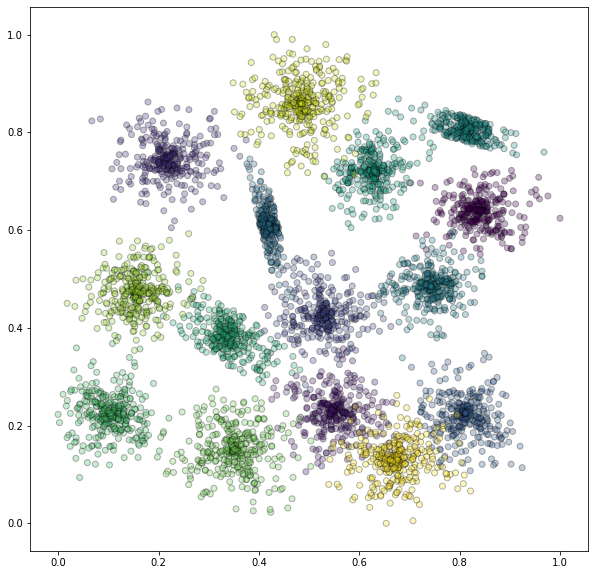

In [188]:
points, labels = np.loadtxt('data/clustering.txt'), np.loadtxt('data/clustering_labels.txt')
points = MinMaxScaler().fit_transform(points) 

labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [193]:
### BEGIN Solution
# >>> your solution here <<<
print('silhouette score for true labels:', silhouette_score(points, labels))
print()

estimators = [KMeans(n_jobs=-1),
              GaussianMixture(),
              Birch(threshold=.01),
              AgglomerativeClustering()]

Y_pred = []
No_clusters = [10, 15, 20]
for C in estimators:
    ss, ami = [], []
    print(C.__class__.__name__)
    
    for m in No_clusters:
        if isinstance(C, GaussianMixture):
            C.n_components = m
        else:
            C.n_clusters = m
            
        y_pred = C.fit_predict(points)
        Y_pred.append(y_pred)
        ss.append(silhouette_score(points, y_pred))
        ami.append(adjusted_mutual_info_score(labels, y_pred))
    print('------------------ \tnumber of clusters')
    print(pd.DataFrame([ss, ami], index=['silhouette', 'adj.mut.info'], columns=No_clusters))
    print()
### END Solution

silhouette score for true labels: 0.6089130527876112

KMeans
------------------ 	number of clusters
                    10        15        20
silhouette    0.517832  0.626305  0.540208
adj.mut.info  0.831873  0.946073  0.906097

GaussianMixture
------------------ 	number of clusters
                    10        15        20
silhouette    0.490973  0.565531  0.564931
adj.mut.info  0.852370  0.922304  0.924963

Birch
------------------ 	number of clusters
                    10        15        20
silhouette    0.506311  0.583750  0.500550
adj.mut.info  0.847076  0.904516  0.882974

AgglomerativeClustering
------------------ 	number of clusters
                    10        15        20
silhouette    0.504527  0.605961  0.528795
adj.mut.info  0.847743  0.926523  0.913183



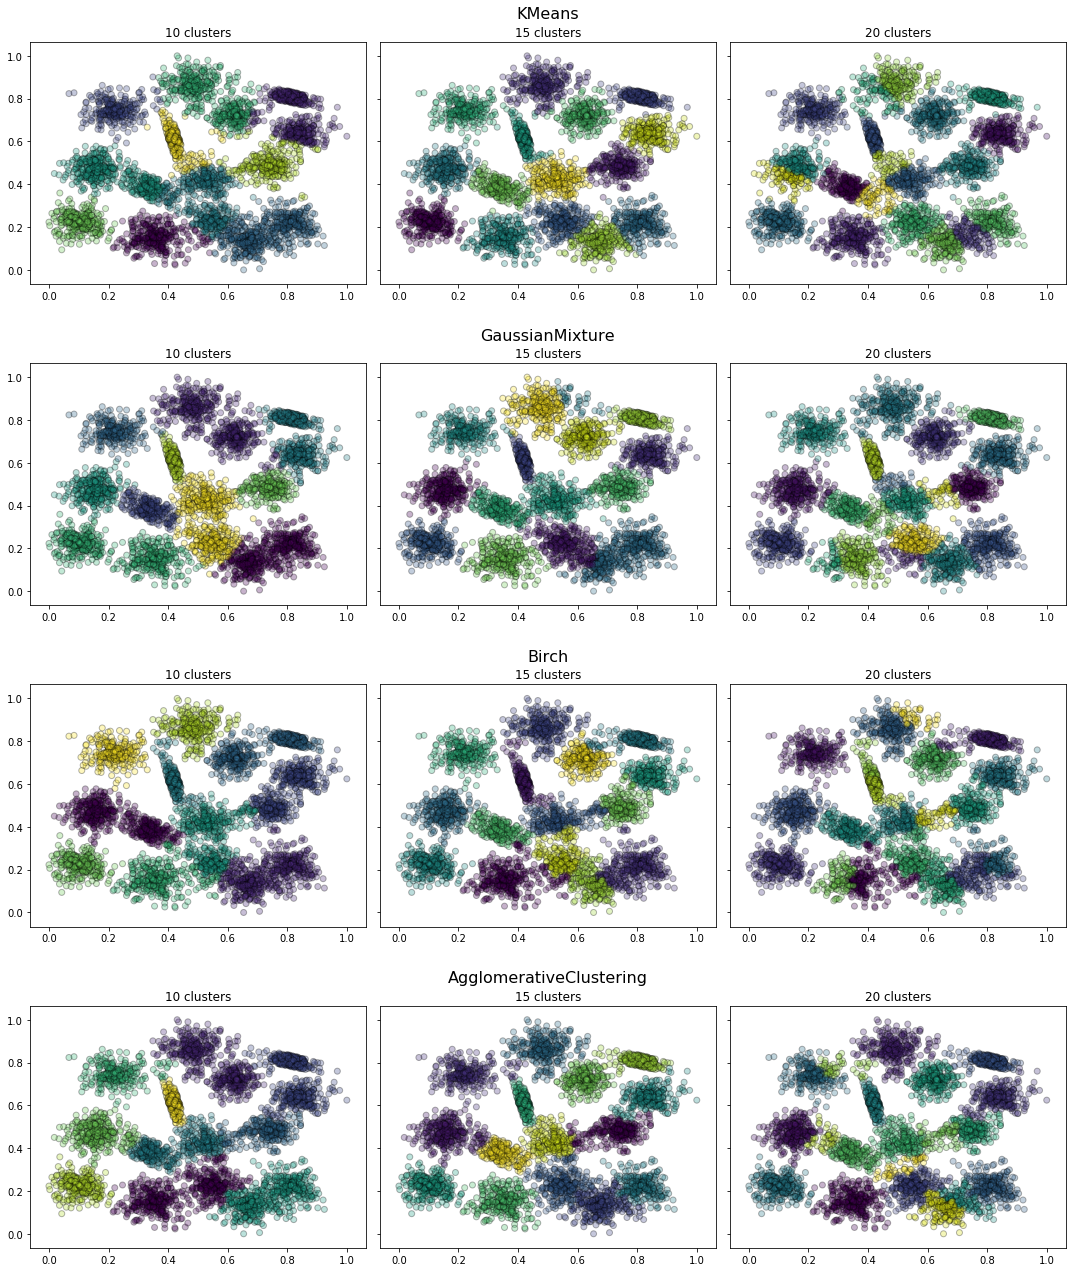

In [191]:
# Apply the algorithm with the true number of clusters and at least two other
# settings thereof: a smaller and a larger number than the true one; visualize the results

### BEGIN Solution
# >>> your solution here <<<
fig, ax = plt.subplots(4, 1, sharey=True, figsize=(15, 18)) 

for i, C in enumerate(estimators):
    ax[i].set_title(f'{C.__class__.__name__}\n', fontsize=16)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i]._frameon = False

for i in range(1,13):
    ax = fig.add_subplot(4,3,i)
    ax.set_title(f'{No_clusters[(i-1)%3]} clusters')
    if (i-1)%3: ax.set_yticklabels([])
    ax.scatter(points[:,0], points[:,1], c=Y_pred[i-1], alpha=0.3, edgecolor='k')

plt.tight_layout()
### END Solution

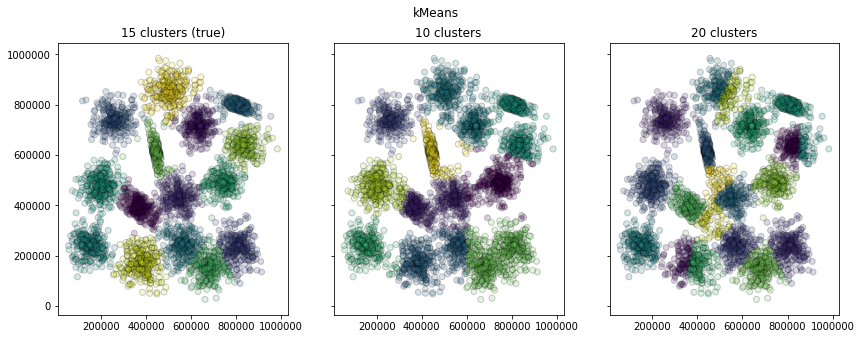

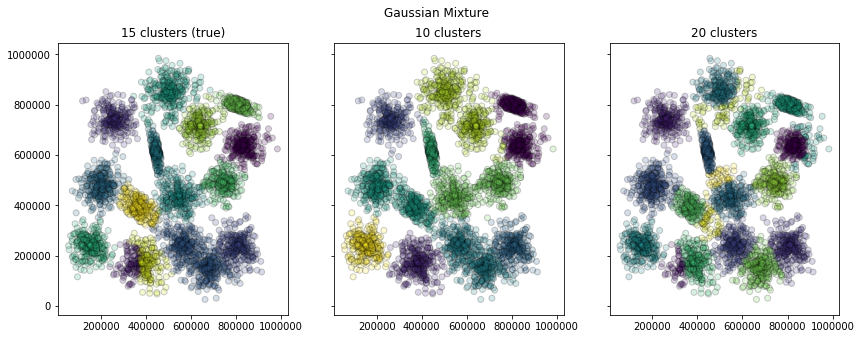

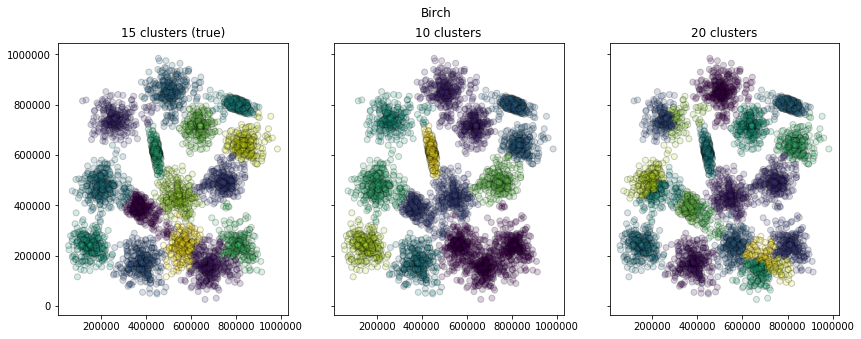

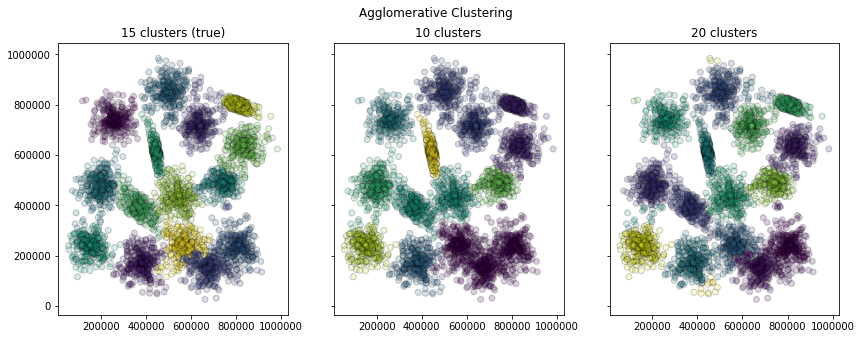

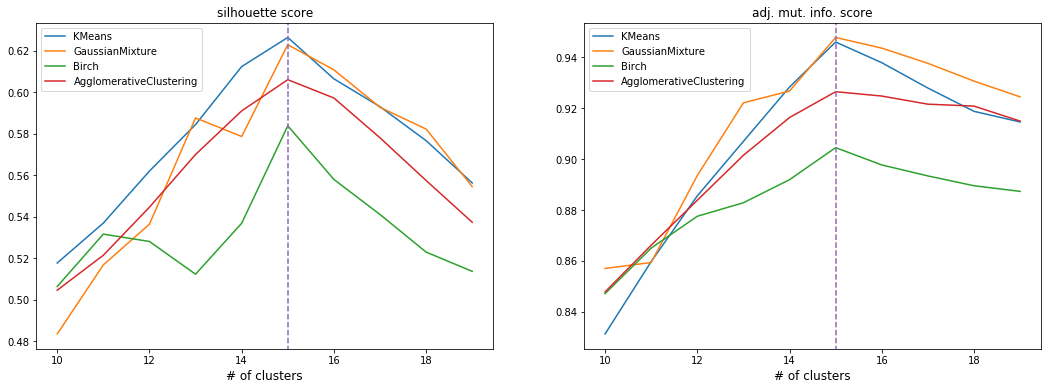

In [211]:
# Calculate the clustering metrics and plot them
### BEGIN Solution
# >>> your solution here <<<
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 6))
for C in estimators:
    ss, ami = [], []
    for m in np.arange(10, 20):
        if isinstance(C, GaussianMixture):
            C.n_components = m
        else:
            C.n_clusters = int(m)    # Birch has some problems with numpy int dtype. It seems like a bug
            
        y_pred = C.fit_predict(points)
        ss.append(silhouette_score(points, y_pred))
        ami.append(adjusted_mutual_info_score(labels, y_pred))
    ax1.plot(np.arange(10, 20), ss, label=C.__class__.__name__)
    ax2.plot(np.arange(10, 20), ami, label=C.__class__.__name__)
     
ax1.set_xlabel('# of clusters', size=12)
ax2.set_xlabel('# of clusters', size=12)
ax1.set_ylim()
ax2.set_ylim()
ax1.plot([15, 15], [0, 1.2], '--')
ax2.plot([15, 15], [0, 1.2], '--')
ax1.set_title('silhouette score', size=12)
ax2.set_title('adj. mut. info. score', size=12)
ax1.legend()
ax2.legend();
### END Solution

### Task 2.2. Finding the Number of Clusters with Bootstrap. (2 points)

For a chosen algorithm find the best number of clusters using bootstrap.

So first based on your observations made at previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.

1. **(1 pt.)** Estimate variance of the metric and construct normal 95% **confidence interval (CI)**;
2. **(1 pt.)** **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__  
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

Number of clusters: 10
	Variance: 2.1996422734996392e-05
	Confidence interval: (0.5099256694095172, 0.5283102664558567)

Number of clusters: 11
	Variance: 5.0348018284714305e-05
	Confidence interval: (0.522650893136208, 0.5504652663230541)

Number of clusters: 12
	Variance: 3.634135738380662e-05
	Confidence interval: (0.5471646315903864, 0.5707954443464489)

Number of clusters: 13
	Variance: 2.187819831093165e-05
	Confidence interval: (0.5740862763197185, 0.5924214008496937)

Number of clusters: 14
	Variance: 1.7024364275690455e-05
	Confidence interval: (0.6053648004549605, 0.6215386551981641)

Number of clusters: 15
	Variance: 1.3548440491007862e-05
	Confidence interval: (0.6198482240492265, 0.6342767757756933)

Number of clusters: 16
	Variance: 3.387783155589657e-05
	Confidence interval: (0.6002881711696859, 0.6231039810265715)

Number of clusters: 17
	Variance: 4.4944941918325125e-05
	Confidence interval: (0.5798749110599953, 0.6061544958038786)

Number of clusters: 18
	Variance: 7.

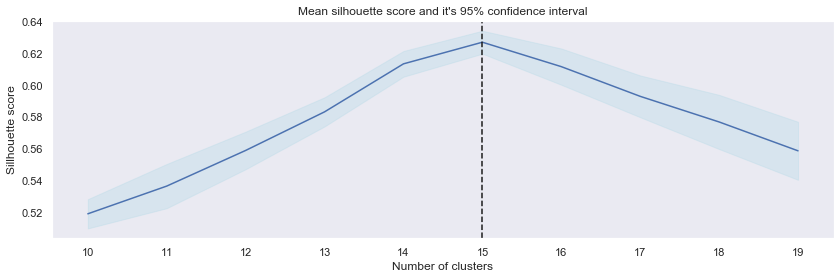

In [109]:
import scipy

from tqdm import tqdm_notebook, tqdm

### BEGIN Solution

cluster_ns = # >>> your solution here <<<
sample_number = # >>> your solution here <<<

for i, n_clusters in tqdm_notebook(enumerate(cluster_ns)):
    # >>> your solution here <<<
    
### END Solution

## Task 3. MNIST, kMNIST component analysis and manifold learning. (6 points)

### Task 3.1. (2 points)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimentionality, decompose the dataset on pinciple components and estimate the cumulative explained variance by each component.

You can either use the proposed method https://www.stat.berkeley.edu/~bickel/mldim.pdf for the sample intrinsic dimention estimation or any other convenient for you. For the first case use can use relised code from here https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4 

1. **(1 pt.)** Estimate the intrinsic dimentionality of the dataset. Provide the plot.
2. **(1 pt.)** Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [2]:
sns.set()
dg = datasets.load_digits()
data = StandardScaler().fit_transform(dg.data)

In [4]:
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstanec betveen the bayeasan statistics
    d = d.sum(axis=1) / ((k - 2) + 1e-8)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [5]:
# Estimate the intrinsic dimentionality of the dataset. 
### BEGIN Solution
# >>> your solution here <<<
intdim_k_repeated = repeated(
    intrinsic_dim_scale_interval, data, 
    mode = 'bootstrap', nb_iter=10, k1=2, k2=65)
intdim_k_repeated = np.array(intdim_k_repeated)
### END Solution

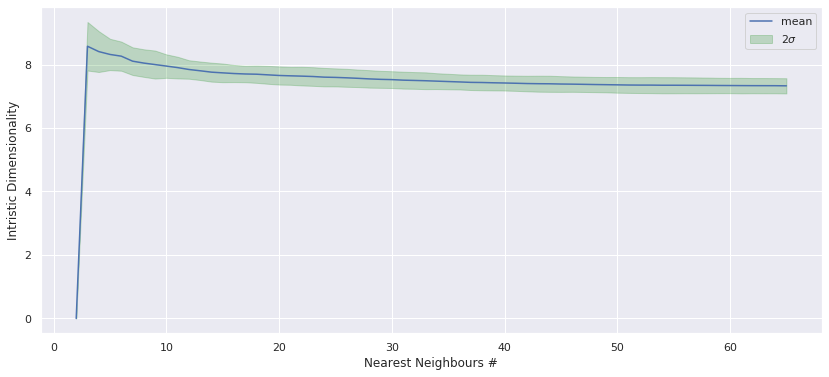

In [6]:
left, right = scipy.stats.norm.interval(
    0.95, loc=intdim_k_repeated.mean(0), scale=intdim_k_repeated.std(0))

plt.figure(figsize=(14,6))
plt.plot(range(2,66), intdim_k_repeated.mean(0), label='mean')
plt.fill_between(
    range(2,66), left, right, alpha=0.2,
    color='green', label =r'$2\sigma$')

plt.xlabel('Nearest Neighbours #')
plt.ylabel('Intristic Dimensionality')
plt.legend();

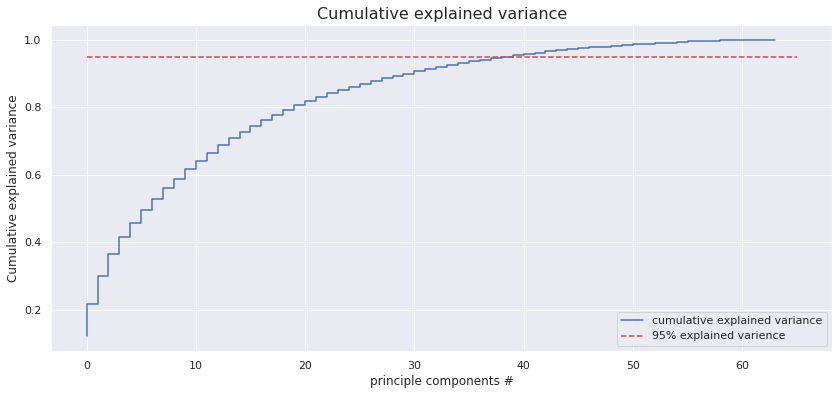

In [7]:
# Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component.
### BEGIN Solution
# >>> your solution here <<<
pca = PCA()
pca.fit(data)

plt.figure(figsize=(14,6))
plt.step(
    range(pca.n_components_),
    np.cumsum(pca.explained_variance_ratio_),  
    c='b', label='cumulative explained variance')

plt.title('Cumulative explained variance', size = 16)
plt.xlabel('principle components #')
plt.ylabel('Cumulative explained variance')

plt.plot([0, 65], [.95, .95], 'r--', label='95% explained varience')
plt.legend();

### END Solution

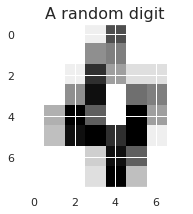

In [8]:
# Plot the example of back-decomposition with 6 different 
# set of components and corresponding explained variance. You can choose any digit from the dataset.

plt.figure(5, figsize=(3, 3))
plt.imshow(dg.images[4], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('A random digit', fontsize=16)
plt.show()

y = dg.target
X = dg.images.reshape(-1, 8*8) / dg.images.max()

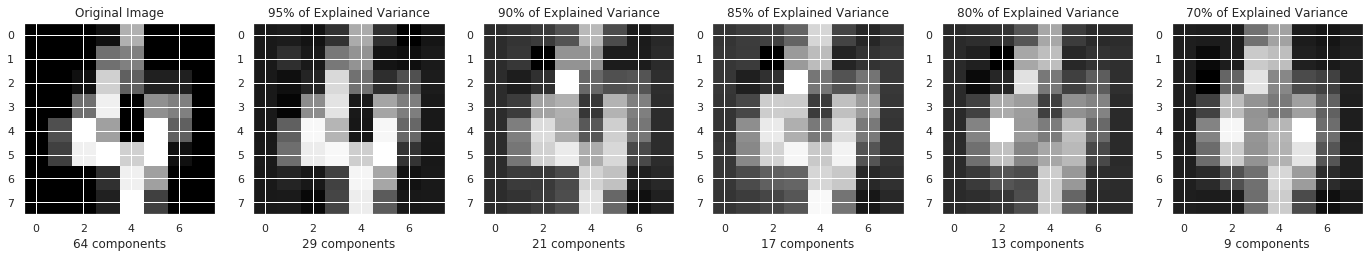

In [21]:
### BEGIN Solution
# >>> your solution here <<<
digits = dg.images.reshape(len(dg.images), -1)

plt.figure(figsize=(24,4))
plt.subplot(161)
plt.imshow(digits[4].reshape(8,8), cmap = plt.cm.gray)
plt.xlabel(f'{digits[4].shape[0]} components')
plt.title('Original Image')

for i, n in enumerate([.95, .9, .85, .8, .7], 2):
    pca = PCA(n)
    plt.subplot(1, 6, i)
    code = pca.fit_transform(digits)
    digits_rd = pca.inverse_transform(code)
    plt.imshow(digits_rd[4].reshape(8, 8),cmap=plt.cm.gray)
    plt.xlabel(f'{pca.n_components_} components')
    plt.title(f'{int(n*100)}% of Explained Variance')
### END Solution

### Task 3.2. (2 points)

Here we will visualise the decompocition, to observe how the data diverges across different manofild learning methods. We are  to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracies on the new features. 

1. Visualise ICA, PCA and Isomap 3D decomposition on 3 components in `plotly`. Be sure the data in whitened (scaled), enjoy nice plots :) 
2. **(1 pt.)** Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according your estimation of intrinsic dimention**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fix the `random_seed = 42`.
3. **(1 pt.)** Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 senteces.

__NOTE:__ In first task, `plotly` will not display the plot in offline notebook, so it is just for you to visualize the projection in 3D.

In [2]:
### BEGIN Solution
# >>> your solution here <<<
dg = datasets.load_digits()
data = StandardScaler().fit_transform(dg.data)

pca = PCA(n_components=3)
S_pca_ = pca.fit_transform(data)# >>> your solution here <<<
### END Solution

In [22]:
digits_3d = pd.DataFrame({
    'x': S_pca_[:, 0], 
    'y': S_pca_[:, 1], 
    'z': S_pca_[:, 2],
    'label': dg['target'],
})

colors = cl.scales['10']['qual']['Paired']
meta = []

for i in range(10):
    x = digits_3d[digits_3d['label'].astype('int') == i]['x']
    y = digits_3d[digits_3d['label'].astype('int') == i]['y']
    z = digits_3d[digits_3d['label'].astype('int') == i]['z']
    
    color = colors[i]
    
    trace = {
        'name': str(i),
        'x': x,
        'y': y,
        'z': z,
        'type': 'scatter3d',
        'mode': 'markers',
        'marker': {
            'size': 5,
            'color': color 
        }
    }
    meta.append(trace)

init_notebook_mode(connected=True)
layout = go.Layout(
    title='MNIST visualization PCA',
    width=900,
    height=600
)

fig = go.Figure(data=meta, layout=layout)

iplot(fig, show_link = False)

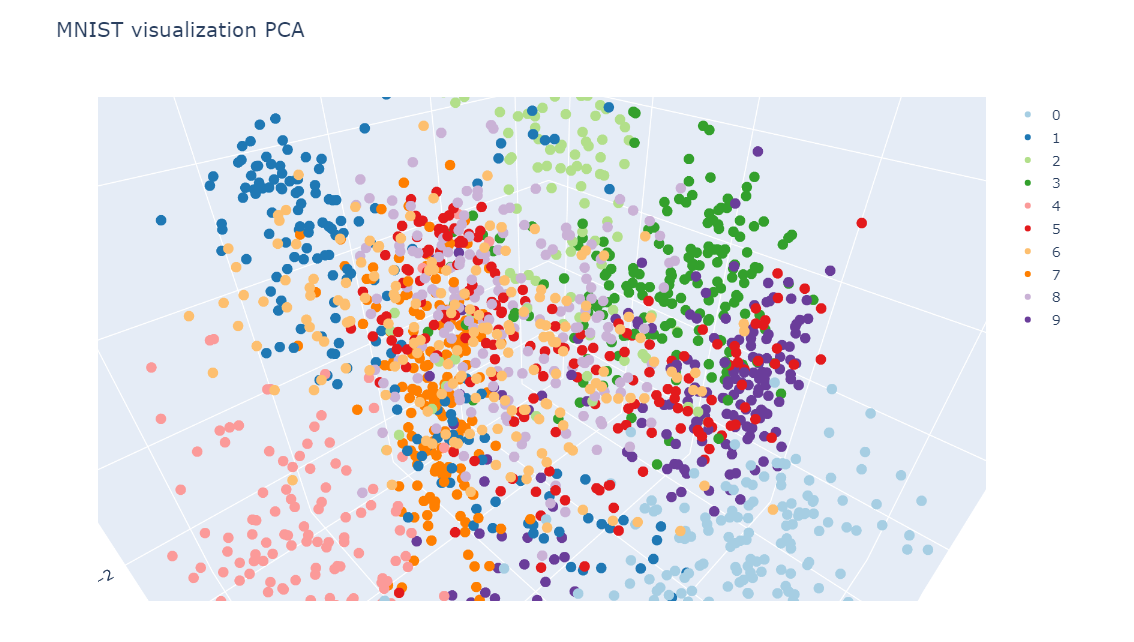

In [29]:
from IPython.display import Image
Image("pca.png")

In [3]:
data

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

mean acc.       std
0   0.933405  0.012802
1   0.852349  0.018356
2   0.692271  0.021858

In [28]:
# >>> your solution here <<<

In [78]:
# >>> your solution here <<<

Statistically significant improvement of PCA decomposition over ICA: p-value  2.085472799316657e-17


In [79]:
# >>> your solution here <<<

### END Solution

Statistically significant improvement of Isomap decomposition over PCA: p-value  7.9465832147781e-12


### Task 3.3. kMNIST dimensionality reduction. (2 points)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engeneer new features with any familiar to you method of Manifold Learning to inclearse the classification accuracy. Use the `KNN` classifier with any hyperparameters your'll choose.

1. __(2 pt.)__ Get accuracy on `test_set` more than `93%`. Is it fair to `fit` with manifold Learning method for both train and test samples? 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performances on `MNIST`. These methods can compete with Autoencoders on `torch`, you will find it in __Part 2__.  Save 3 first components of your projection on `train` sample to `.csv`, we are going to visually compare them later.


In [2]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.decomposition import PCA

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

### BEGIN Solution

# >>> your solution here <<<

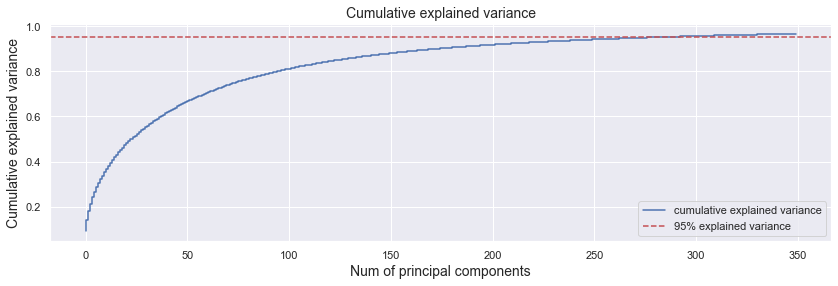

In [94]:
# >>> your solution here <<<

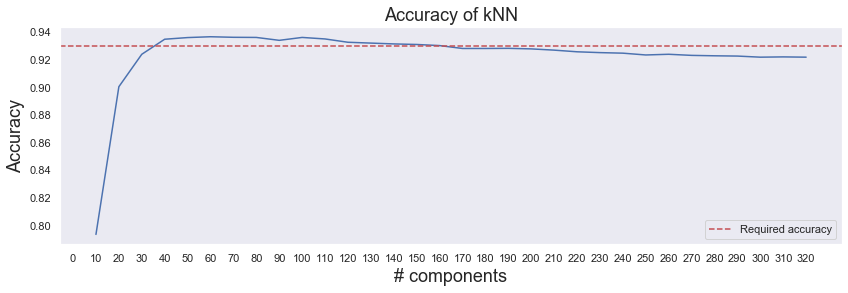

In [93]:
# >>> your solution here <<<
### END Solution

#### Voilla! you are done, have a good day ;)